## Implementing a Convolutional Neural Network Using Keras for Computer Vision

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # suppress info and warning messages
import tensorflow.keras as keras
import math
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Part 1. Define ML Problem 

We will implement a convolutional neural network to solve a handwriting recognition problem. The neural network will classify a hand-written digit. 

#### Define the Label

We will work with the MNIST data set, a famous collection of images used for handwriting recognition. It contains labeled images of handwritten digits from 0 to 9. Therefore, the label is a digit from 0 and 9. This is a multiclass classification problem. 


#### Identify Features

Each example corresponds to one hand-written image. The features will be comprised of numerical feature vectors (an n-dimensional array) that contain grey-scale pixel values that range from 0 to 255.



## Part 2. Import the Data Set and Create Training and Test Sets

The MNIST data set comes preloaded in Keras. The `load_data()` function returns the data set split into training and test subsets. The cell below loads the data set and contains training and test data.


In [2]:
# The mnist data set comes preloaded 
mnist = keras.datasets.mnist

# Create training and test sets
(X_train, y_train),(X_test, y_test) = mnist.load_data()


### Inspect the Data

In [3]:
print(X_train.dtype, X_train.shape)
print(y_train.dtype, y_train.shape)
print(X_test.dtype, X_test.shape)
print(y_test.dtype, y_test.shape)

uint8 (60000, 28, 28)
uint8 (60000,)
uint8 (10000, 28, 28)
uint8 (10000,)


Notice that the training and test data sets are NumPy arrays. 

* <b>Training data:</b><br>
    `X_train` is a three-dimensional array of shape `(60000, 28, 28)`. It contains grayscale image data. Pixel values range from 0 to 255.<br>
    `y_train` is a one-dimensional array with shape `(6000,)`. It contains digit labels (integers in range 0-9).


* <b>Test data:</b><br>
    `X_test` is a three-dimensional array of shape `(10000, 28, 28)`. It contains grayscale image data. Pixel values range from 0 to 255.<br>`y_test` is a one-dimensional array with shape `(1000,)`. It contains digit labels (integers in range 0-9).

Let's take a look at the data in more detail. Let's inspect the first example (which contains an image) in `X_train`:


In [4]:
X_train[0].shape

(28, 28)

In [5]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

As expected, the first example in the training data is a 28 x 28 array.  This array encodes the grayscale value of the  hand-written image, i.e., each entry in the 28 x 28 array encodes the intensity (darkness) of the corresponding pixel. 

### Visualize the Data

Let's visualize an image below.

<Axes: >

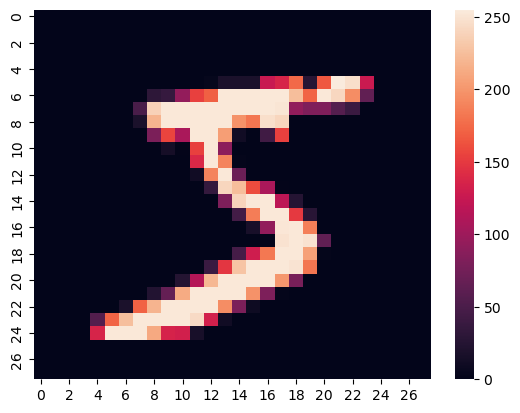

In [6]:
sns.heatmap(X_train[0])

<b>Task</b>: Inspect the corresponding label in `y_train` to confirm that the label matches the image you see in the heatmap above.

In [7]:
y_train[0]

5

Which digit appeared in your heatmap? Did it match its label? Record your findings in the cell below.

The number in my heatmap matches the label which is 5.

Let's use this function to inspect a few more examples in the training data. 

In [8]:
# Function to visualize the data
def plot_imgs(images, labels=None):
    subplots_x = int(math.ceil(len(images) / 5))
    plt.figure(figsize=(10,2*subplots_x))
    for i in range(min(len(images), subplots_x*5)):
        plt.subplot(subplots_x,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        if labels is not None:
            plt.xlabel(labels[i])
    plt.show()
    

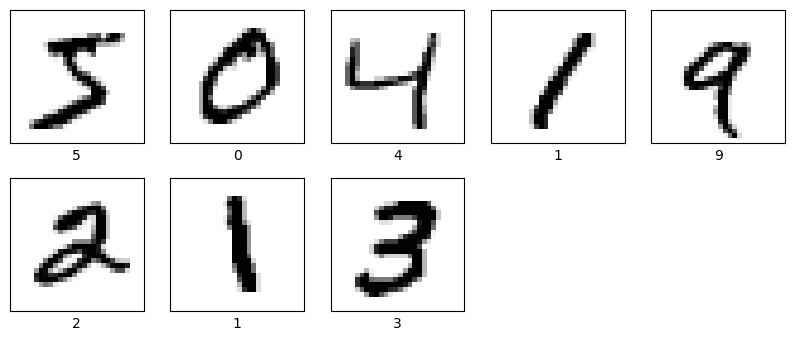

In [9]:
# Visualize some training examples
plot_imgs(X_train[:8], y_train[:8])

## Part 3. Prepare the Data

Let's now prepare our data to be suitable for a CNN.

#### Scale the Data

Our MNIST data is raw data containing pixel values between 0 and 255. Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the training process. Therefore, it is a good practice to normalize the pixel values so that each pixel has a value between 0 and 1. This can be done by dividing all pixels values by the largest pixel value; that is 255. 

In [10]:
X_train = X_train/255.0
X_test = X_test/255.0

print(X_train.min(), X_train.max(), X_test.min(), X_test.max())

0.0 1.0 0.0 1.0


#### Reshape the Data
A CNN in Keras requires a 4-dimensional array as input in the form: `(num_examples, image_dimension_X, image_dimension_Y, num_channels)`.

Since grayscale has only one color channel, every example in `X_train` would have the shape `(28, 28, 1)`. `X_test` should have the same dimensions.

In [11]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
print(X_train.shape, X_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


## Part 4. Construct the Convolutional Neural Network

### Step 1. Define Model Structure

Next we will create our convolutional neural network structure. A CNN has three different types of hidden layers: a convolutional layer, a pooling layer, and a fully connected layer. When constructing a convolutional hidden layer, we will compose a 2D convolution, followed by a batch normalization, followed by an activation function. 

Let's create the CNN structure (Note that there are different ways one can choose to construct a CNN in Keras). We will create an input layer, five hidden layers and an output layer:

* <b>Input layer</b>: The input layer will have the input shape corresponding to the number of features. 
* <b>Hidden layers</b>: We will create five hidden layers:
    * Four hidden layers will be convolutional layers. They will be comprised of a 2D convolution, followed by a batch normalization, followed by an activation function. In this case, the activation function of choice is ReLU.
    * One hidden layer will be a pooling layer. We will add a layer that uses Global Average Pooling. This is a pooling operation designed to replace the final fully connected layer in classical CNN. 
* <b>Output layer</b>: The output layer will have a width of 10. 

To construct the CNN model using Keras, we will do the following:

* As before, we will use the Keras `Sequential` class to group a stack of layers. This will be our CNN model object. For more information, consult the Keras online [Sequential class documentation](https://keras.io/api/models/sequential/#sequential-class).
* We will use the `InputLayer` class to create the input layer. For more information, consult the Keras online [InputLayer class documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer).
* We will use the `Conv2D` class to create the convolutional layers. For more information, consult the Keras online [Conv2D class documentation](https://keras.io/api/layers/convolution_layers/convolution2d/).
    * For batch normalization, we will use the `BatchNormalization` class. For more information, consult the Keras online [BatchNormalization class documentation](https://keras.io/api/layers/normalization_layers/batch_normalization/).
    * For the activation function, we will use the `ReLU` class. For more information, consult the Keras online [ReLU class documentation](https://keras.io/api/layers/activation_layers/relu/).
* We will use the `GlobalAveragePooling2D` class to create the pooling layer. For more information, consult the Keras online [GlobalAveragePooling2D class documentation](https://keras.io/api/layers/pooling_layers/global_average_pooling2d/
).
* Finally, we will use the `Dense` class to create the output layer. For more information, consult the Keras online [Dense class documentation](https://keras.io/api/layers/core_layers/dense/).
* We will add each layer to the CNN model object.  

In [12]:
# 1. Create CNN model object
cnn_model = keras.Sequential()

# 2. Create the input layer and add it to the model object: 
input_layer = keras.layers.InputLayer(shape=X_train.shape[1:])
cnn_model.add(input_layer)

# 3. Create the first convolutional layer and add it to the model object:
conv_1 = keras.layers.Conv2D(16, 3)
batchNorm_1 = keras.layers.BatchNormalization()
ReLU_1 = keras.layers.ReLU()
cnn_model.add(conv_1)
cnn_model.add(batchNorm_1)
cnn_model.add(ReLU_1)

# 4. Create the second convolutional layer and add it to the model object:
conv_2 = keras.layers.Conv2D(32, 3)
batchNorm_2 = keras.layers.BatchNormalization()
ReLU_2 = keras.layers.ReLU()
cnn_model.add(conv_2)
cnn_model.add(batchNorm_2)
cnn_model.add(ReLU_2)

# 5. Create the third convolutional layer and add it to the model object:
conv_3 = keras.layers.Conv2D(64, 3)
batchNorm_3 = keras.layers.BatchNormalization()
ReLU_3 = keras.layers.ReLU()
cnn_model.add(conv_3)
cnn_model.add(batchNorm_3)
cnn_model.add(ReLU_3)

# 6. Create the fourth convolutional layer and add it to the model object:
conv_4 = keras.layers.Conv2D(128, 3)
batchNorm_4 = keras.layers.BatchNormalization()
ReLU_4 = keras.layers.ReLU()
cnn_model.add(conv_4)
cnn_model.add(batchNorm_4)
cnn_model.add(ReLU_4)

# 7. Create the pooling layer and add it to the model object:
pooling_layer = keras.layers.GlobalAveragePooling2D()
cnn_model.add(pooling_layer)

# 8. Create the output layer and add it to the model object:
output_layer = keras.layers.Dense(10)
cnn_model.add(output_layer)
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 22, 22, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,402 (388.29 KB)

 Trainable params: 98,922 (386.41 KB)

 Non-trainable params: 480 (1.88 KB)

### Step 2. Define the Optimization Function

In [13]:
sgd_optimizer = keras.optimizers.SGD(learning_rate=0.1)

### Step 3. Define the loss function

In [14]:
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

### Step 4. Compile the model

In [15]:
cnn_model.compile(optimizer=sgd_optimizer, loss=loss_fn, metrics=['accuracy'])

## Part 5. Fit the Model to the Training Data

We can now fit the CNN model to the training data. Since there are 60,000 training examples and nearly 100,000 parameters to fit, this may take a while to run. 

In [16]:
num_epochs = 1 # Number of epochs

t0 = time.time() # start time

history = cnn_model.fit(x=X_train, y=y_train, epochs=num_epochs)

t1 = time.time() # stop time

print('Elapsed time: %.2fs' % (t1-t0))

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 210s 112ms/step - accuracy: 0.8142 - loss: 0.7128
Elapsed time: 210.14s


## Part 6. Evaluate the Model's Performance

Let's now evaluate our CNN model's performance on our test data and see how it did.


In [17]:
loss, accuracy = cnn_model.evaluate(X_test, y_test)

print('Loss: ', str(loss) , 'Accuracy: ', str(accuracy))

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9544 - loss: 0.1672
Loss:  0.14718273282051086 Accuracy:  0.9595999717712402


Next we'll make some predictions on the test set and see for ourselves how accurate these predictions are.

In the code cell below, we call the `plot_imgs()` functions with the first 25 images in `X_test` as the first argument, and the first 25 labels in `predictions` as the second argument. 

The result should be a display of the first 25 images in the test set `X_test`, and below each image, a display of the predicted digit.

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step


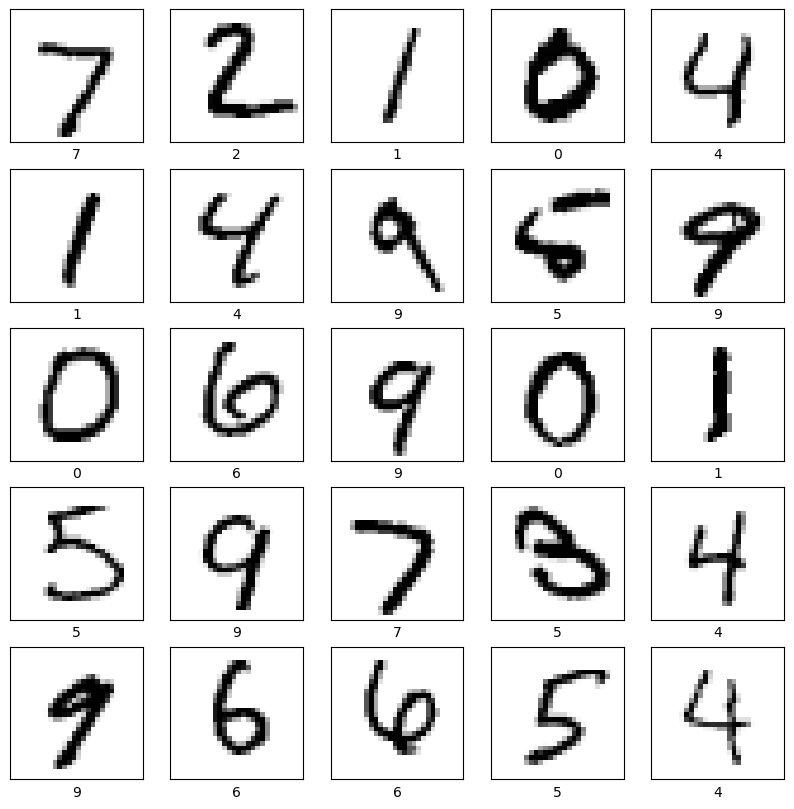

In [18]:
# Make predictions on the test set
logits = cnn_model.predict(X_test)
predictions = logits.argmax(axis = 1)


## Plot individual predictions
plot_imgs(X_test[:25], predictions[:25])